In [2]:
import os
import re
import pickle
import string
import unicodedata
from random import randint

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from wordcloud import STOPWORDS, WordCloud

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, TimeDistributed

In [3]:
!pip install -q contractions==0.0.48

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.1 MB/s eta 0:00:00


In [4]:
from contractions import contractions_dict

for key, value in list(contractions_dict.items())[:10]:
    print(f'{key} == {value}')

I'm == I am
I'm'a == I am about to
I'm'o == I am going to
I've == I have
I'll == I will
I'll've == I will have
I'd == I would
I'd've == I would have
Whatcha == What are you
amn't == am not


In [5]:
filename1 = '/content/news_summary.csv'
filename2 = '/content/news_summary_more.csv'

df1 = pd.read_csv(filename1, encoding='iso-8859-1').reset_index(drop=True)
df2 = pd.read_csv(filename2, encoding='iso-8859-1').reset_index(drop=True)

In [6]:
df1.sample(5)
df2.sample(5)


,headlines,text
76024,"I feel they betrayed me, says fired Google emp...","Former Google engineer James Damore, who was f..."
36209,"Man steals Maha govt bus, rams it into tree mi...",A man hailing from Uttar Pradesh was arrested ...
5025,Only BJP will build Ram Mandir and no one else...,Uttar Pradesh CM Yogi Adityanath on Sunday sai...
19497,Russia unveils President Putin's new limousine...,Russian President Vladimir Putin's new limousi...
924,"Now, 3 soldiers working for you: Rahul on Priy...",Referring to the appointment of Priyanka Gandh...


In [7]:
df1_columns = df1.columns.tolist()
df1_columns.remove('headlines')
df1_columns.remove('text')
df1.drop(df1_columns, axis='columns', inplace=True)

df = pd.concat([df1, df2], axis='rows')
del df1, df2

# Shuffling the df
df = df.sample(frac=1).reset_index(drop=True)

print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 102915


,headlines,text
87832,Donald Trump denies he called White House a 'd...,Refuting reports that he called the White Hous...
18111,"NCP, Congress win in Navi Mumbai Municipal Cor...",The Nationalist Congress Party (NCP) and their...
96706,Sentence against Abu Salem for 1993 Mumbai bla...,A special court constituted under the Terroris...
43388,"PM Modi to meet Swiss Prez, Swedish PM during ...",Prime Minister Narendra Modi will hold bilater...
36885,Virender Sehwag dresses up as a 'Baba' to bles...,Former Indian cricketer Virender Sehwag dresse...


In [8]:
def expand_contractions(text, contraction_map=contractions_dict):
    # Using regex for getting all contracted words
    contractions_keys = '|'.join(contraction_map.keys())
    contractions_pattern = re.compile(f'({contractions_keys})', flags=re.DOTALL)

    def expand_match(contraction):
        # Getting entire matched sub-string
        match = contraction.group(0)
        expanded_contraction = contraction_map.get(match)
        if not expand_contractions:
            print(match)
            return match
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text


expand_contractions("y'all can't expand contractions i'd think")

'you all can not expand contractions id think'

In [9]:
# Converting to lowercase
df.text = df.text.apply(str.lower)
df.headlines = df.headlines.apply(str.lower)

df.sample(5)

,headlines,text
29433,foot overbridges at mumbai stations to be clos...,"to prevent stampedes, the central railway (cr)..."
75229,"unfortunately, actresses are treated like time...",actor akshay kumar has said that unfortunately...
85376,selena gomez in hospital for mental health tre...,selena gomez is in hospital for mental health ...
55042,disha patani slams news channel for calling he...,actress disha patani took to twitter to slam a...
41355,us website buying maple leaves for $1 each fro...,a company in united states' new england is pay...


In [10]:
df.headlines = df.headlines.apply(expand_contractions)
df.text = df.text.apply(expand_contractions)
df.sample(5)

,headlines,text
85084,china tells themirates to follow one china policy,"themirates revealed that it has been ""instruct..."
39097,sara ali khans look from debut film kedarnath ...,the first look of sara ali khan from her debut...
24631,"bjp, cong are brothers who can not be believed...",addressingã¢ââ a public meeting ahead of the...
89752,lawmakers post thempty seat pic after fb ceo d...,lawmakers from the uk and other nations have c...
51204,"sena calls bjp raj bypoll loss interval, 2019 ...",a day after the bjp lost the rajasthan bypolls...


In [11]:
# Remove puncuation from word
def rm_punc_from_word(word):
    clean_alphabet_list = [
        alphabet for alphabet in word if alphabet not in string.punctuation
    ]
    return ''.join(clean_alphabet_list)

print(rm_punc_from_word('#cool!'))


# Remove puncuation from text
def rm_punc_from_text(text):
    clean_word_list = [rm_punc_from_word(word) for word in text]
    return ''.join(clean_word_list)

print(rm_punc_from_text("Frankly, my dear, I don't give a damn"))

cool
Frankly my dear I dont give a damn


In [12]:
# Remove numbers from text
def rm_number_from_text(text):
    text = re.sub('[0-9]+', '', text)
    return ' '.join(text.split())  # to rm `extra` white space

print(rm_number_from_text('You are 100times more sexier than me'))
print(rm_number_from_text('If you taught yes then you are 10 times more delusional than me'))

You are times more sexier than me
If you taught yes then you are times more delusional than me


In [13]:
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
# Remove stopwords from text
def rm_stopwords_from_text(text):
    _stopwords = stopwords.words('english')
    text = text.split()
    word_list = [word for word in text if word not in _stopwords]
    return ' '.join(word_list)

rm_stopwords_from_text("Love means never having to say you're sorry")

'Love means never say sorry'

In [15]:
# Cleaning text
def clean_text(text):
    text = text.lower()
    text = rm_punc_from_text(text)
    text = rm_number_from_text(text)
    text = rm_stopwords_from_text(text)

    # there are hyphen(–) in many titles, so replacing it with empty str
    # this hyphen(–) is different from normal hyphen(-)
    text = re.sub('–', '', text)
    text = ' '.join(text.split())  # removing `extra` white spaces

    # Removing unnecessary characters from text
    text = re.sub("(\\t)", ' ', str(text)).lower()
    text = re.sub("(\\r)", ' ', str(text)).lower()
    text = re.sub("(\\n)", ' ', str(text)).lower()

    # remove accented chars ('Sómě Áccěntěd těxt' => 'Some Accented text')
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode(
        'utf-8', 'ignore'
    )

    text = re.sub("(__+)", ' ', str(text)).lower()
    text = re.sub("(--+)", ' ', str(text)).lower()
    text = re.sub("(~~+)", ' ', str(text)).lower()
    text = re.sub("(\+\++)", ' ', str(text)).lower()
    text = re.sub("(\.\.+)", ' ', str(text)).lower()

    text = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", ' ', str(text)).lower()

    text = re.sub("(mailto:)", ' ', str(text)).lower()
    text = re.sub(r"(\\x9\d)", ' ', str(text)).lower()
    text = re.sub("([iI][nN][cC]\d+)", 'INC_NUM', str(text)).lower()
    text = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", 'CM_NUM',
                  str(text)).lower()

    text = re.sub("(\.\s+)", ' ', str(text)).lower()
    text = re.sub("(\-\s+)", ' ', str(text)).lower()
    text = re.sub("(\:\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    try:
        url = re.search(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', str(text))
        repl_url = url.group(3)
        text = re.sub(r'((https*:\/*)([^\/\s]+))(.[^\s]+)', repl_url, str(text))
    except Exception as e:
        pass

    text = re.sub("(\s+)", ' ', str(text)).lower()
    text = re.sub("(\s+.\s+)", ' ', str(text)).lower()

    return text

clean_text("Mrs. Robinson, you're trying to seduce me, aren't you?")

'mrs robinson youre trying seduce arent'

In [16]:
df.text = df.text.apply(clean_text)
df.headlines = df.headlines.apply(clean_text)
df.sample(5)

,headlines,text
32469,india changes fourdeold definition blindness,according new definition blindness adopted ind...
81775,phone numbers seized bihar shelter home accuse...,raid bihars muzaffarpur jail police recovered ...
78427,foodpanda india may buy defunct food startup h...,olaowned online food ordering delivery startup...
42072,f driver crashes race ends rides back another car,ferraris formula one driver sebastian vettel c...
28311,india batsman comes bat wearing one glove,india ankit bawne forgot take one gloves going...


In [17]:
# saving the cleaned data
df.to_csv('cleaned_data.csv')

In [18]:
# To customize colours of wordcloud texts
def wc_blue_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(214, 67%%, %d%%)" % randint(60, 100)


# stopwords for wordcloud
def get_wc_stopwords():
    wc_stopwords = set(STOPWORDS)

    # Adding words to stopwords
    # these words showed up while plotting wordcloud for text
    wc_stopwords.add('s')
    wc_stopwords.add('one')
    wc_stopwords.add('using')
    wc_stopwords.add('example')
    wc_stopwords.add('work')
    wc_stopwords.add('use')
    wc_stopwords.add('make')

    return wc_stopwords


# plot wordcloud
def plot_wordcloud(text, color_func):
    wc_stopwords = get_wc_stopwords()
    wc = WordCloud(stopwords=wc_stopwords, width=1200, height=600, random_state=0).generate(text)

    f, axs = plt.subplots(figsize=(20, 10))
    with sns.axes_style("ticks"):
        sns.despine(offset=10, trim=True)
        plt.imshow(wc.recolor(color_func=color_func, random_state=0), interpolation="bilinear")
        plt.xlabel('WordCloud')

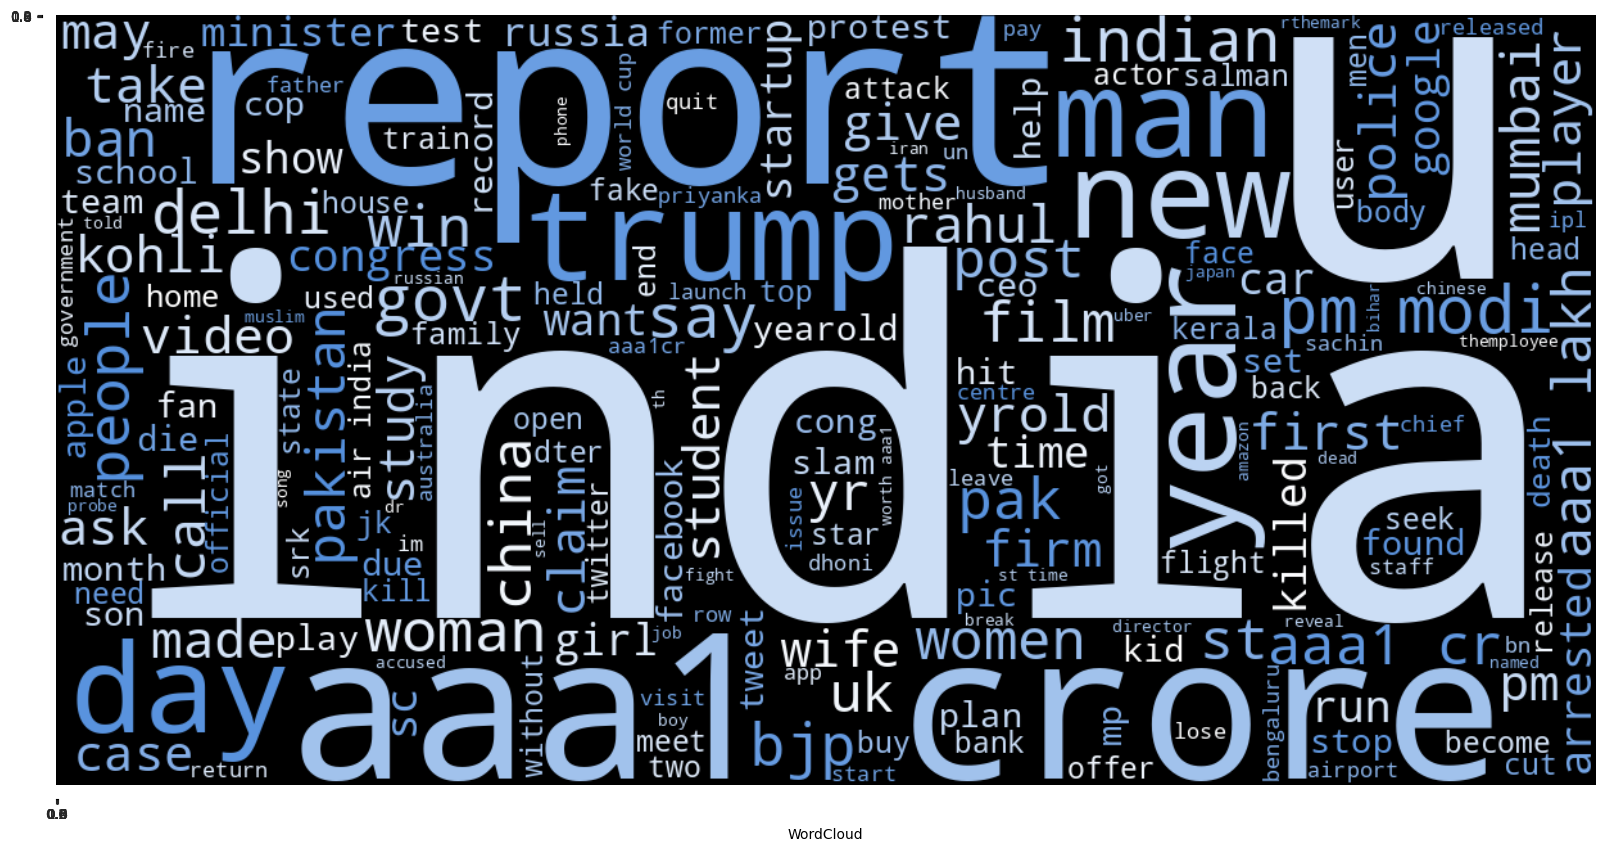

In [19]:
plot_wordcloud(' '.join(df.headlines.values.tolist()), wc_blue_color_func)

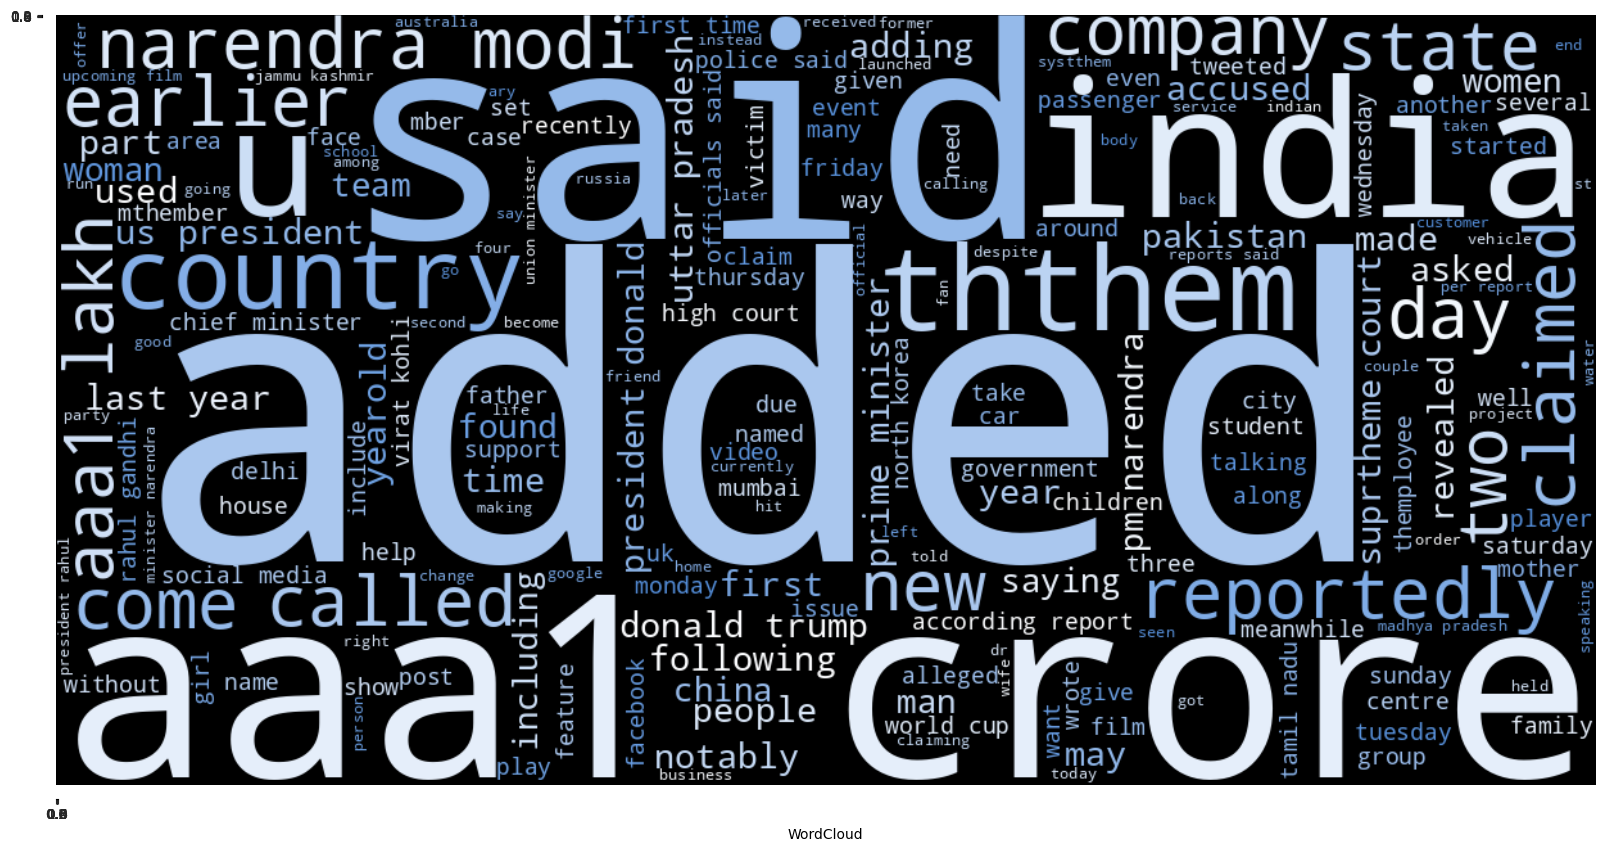

In [20]:
plot_wordcloud(' '.join(df.text.values.tolist()), wc_blue_color_func)

In [21]:
df.headlines = df.headlines.apply(lambda x: f'_START_ {x} _END_')

In [22]:
start_token = 'sostok'
end_token = 'eostok'
df.headlines = df.headlines.apply(lambda x: f'{start_token} {x} {end_token}')

In [23]:
df.sample(5)

,headlines,text
4667,sostok _START_ payments startup cashfree raise...,bengalurubased payments startup cashfree raise...
87575,sostok _START_ thembarrassed get attention ins...,speaking indias teams triumph world cup coach ...
3188,sostok _START_ gambling firm fined record aaa1...,gambling firm hit record aa million aaa1 crore...
37314,sostok _START_ rahul visit grandmother italy b...,congress vicepresident rahul gandhi said takin...
16718,sostok _START_ trai plans rules new telcos rel...,telecom regulatory authority india plans start...


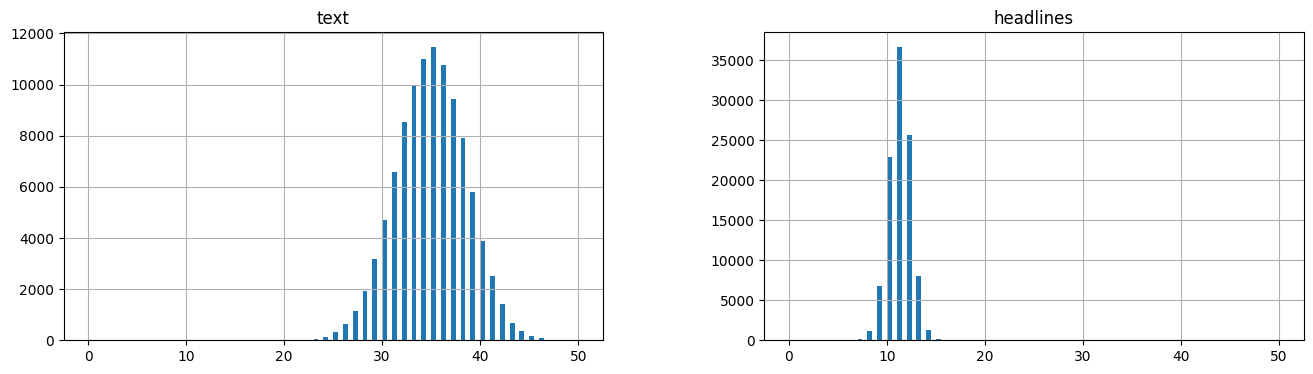

In [24]:
text_count = [len(sentence.split()) for sentence in df.text]
headlines_count = [len(sentence.split()) for sentence in df.headlines]

pd.DataFrame({'text': text_count, 'headlines': headlines_count}).hist(bins=100, figsize=(16, 4), range=[0, 50])
plt.show()

In [25]:
# To check how many rows in a column has length (of the text) <= limit
def get_word_percent(column, limit):
    count = 0
    for sentence in column:
        if len(sentence.split()) <= limit:
            count += 1

    return round(count / len(column), 2)


# Check how many % of headlines have 0-13 words
print(get_word_percent(df.headlines, 13))

# Check how many % of summary have 0-42 words
print(get_word_percent(df.text, 42))

0.99
0.99


In [26]:
max_text_len = 42
max_summary_len = 15

In [27]:
# select the summary and text between their defined max lens respectively
def trim_text_and_summary(df, max_text_len, max_summary_len):
    cleaned_text = np.array(df['text'])
    cleaned_summary = np.array(df['headlines'])

    short_text = []
    short_summary = []

    for i in range(len(cleaned_text)):
        if len(cleaned_text[i].split()) <= max_text_len and len(
            cleaned_summary[i].split()
        ) <= max_summary_len:
            short_text.append(cleaned_text[i])
            short_summary.append(cleaned_summary[i])

    df = pd.DataFrame({'text': short_text, 'summary': short_summary})
    return df


df = trim_text_and_summary(df, max_text_len, max_summary_len)
print(f'Dataset size: {len(df)}')
df.sample(5)

Dataset size: 101551


,text,summary
2541,delhis patiala house court allowed congress le...,sostok _START_ court allows tharoor travel abr...
45198,digital payments major paytm acquired new delh...,sostok _START_ paytm acquires tech startup bac...
101358,indian cricket team played first odi years ago...,sostok _START_ india played odis cricket histo...
48961,coproducers rajkumrao shraddha kapoor starrer ...,sostok _START_ stree coproducers get financial...
39859,law mandating equal pay men women iceland came...,sostok _START_ icelandic law making equal pay ...


In [28]:
# rare word analysis
def get_rare_word_percent(tokenizer, threshold):
    # threshold: if the word's occurrence is less than this then it's rare word

    count = 0
    total_count = 0
    frequency = 0
    total_frequency = 0

    for key, value in tokenizer.word_counts.items():
        total_count += 1
        total_frequency += value
        if value < threshold:
            count += 1
            frequency += value

    return {
        'percent': round((count / total_count) * 100, 2),
        'total_coverage': round(frequency / total_frequency * 100, 2),
        'count': count,
        'total_count': total_count
    }

In [29]:
# Splitting the training and validation sets
x_train, x_val, y_train, y_val = train_test_split(
    np.array(df['text']),
    np.array(df['summary']),
    test_size=0.1,
    random_state=1,
    shuffle=True
)

In [30]:
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

x_tokens_data = get_rare_word_percent(x_tokenizer, 4)
print(x_tokens_data)

{'percent': 65.34, 'total_coverage': 2.94, 'count': 65719, 'total_count': 100578}


In [31]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [32]:
# else use this
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [33]:
# one-hot-encoding
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

# padding upto max_text_len
x_train_padded = pad_sequences(x_train_sequence, maxlen=max_text_len, padding='post')
x_val_padded = pad_sequences(x_val_sequence, maxlen=max_text_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
x_vocab_size = len(x_tokenizer.word_index) + 1

# else use this
# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

100579


In [34]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

y_tokens_data = get_rare_word_percent(y_tokenizer, 6)
print(y_tokens_data)

{'percent': 69.28, 'total_coverage': 4.77, 'count': 26220, 'total_count': 37845}


In [35]:
# else use this
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [36]:
# save tokenizer
with open('y_tokenizer', 'wb') as f:
    pickle.dump(y_tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# one-hot-encoding
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

# padding upto max_summary_len
y_train_padded = pad_sequences(y_train_sequence, maxlen=max_summary_len, padding='post')
y_val_padded = pad_sequences(y_val_sequence, maxlen=max_summary_len, padding='post')

# if you're not using num_words parameter in Tokenizer then use this
y_vocab_size = len(y_tokenizer.word_index) + 1

# else use this
# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

37846


In [38]:
# removing summary which only has sostok & eostok
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_padded)
remove_val_indexes = remove_indexes(y_val_padded)

y_train_padded = np.delete(y_train_padded, remove_train_indexes, axis=0)
x_train_padded = np.delete(x_train_padded, remove_train_indexes, axis=0)

y_val_padded = np.delete(y_val_padded, remove_val_indexes, axis=0)
x_val_padded = np.delete(x_val_padded, remove_val_indexes, axis=0)

In [50]:
latent_dim = 240
embedding_dim = 300
num_epochs = 30

In [ ]:
# def get_embedding_matrix(tokenizer, embedding_dim, vocab_size=None):
#     word_index = tokenizer.word_index
#     voc = list(word_index.keys())

#     path_to_glove_file = '/content/glove.6B.300d.txt'

#     embeddings_index = {}
#     with open(path_to_glove_file) as f:
#         for line in f:
#             word, coefs = line.split(maxsplit=1)
#             coefs = np.fromstring(coefs, "f", sep=" ")
#             embeddings_index[word] = coefs

#     print("Found %s word vectors." % len(embeddings_index))

#     num_tokens = len(voc) + 2 if not vocab_size else vocab_size
#     hits = 0
#     misses = 0

#     # Prepare embedding matrix
#     embedding_matrix = np.zeros((num_tokens, embedding_dim))
#     for word, i in word_index.items():
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             # Words not found in embedding index will be all-zeros.
#             # This includes the representation for "padding" and "OOV"
#             embedding_matrix[i] = embedding_vector
#             hits += 1
#         else:
#             misses += 1
#     print("Converted %d words (%d misses)" % (hits, misses))

#     return embedding_matrix


# x_embedding_matrix = get_embedding_matrix(x_tokenizer, embedding_dim, x_vocab_size)
# y_embedding_matrix = get_embedding_matrix(y_tokenizer, embedding_dim, y_vocab_size)

Found 400000 word vectors.
Converted 55278 words (44438 misses)
Found 400000 word vectors.
Converted 27046 words (10369 misses)


In [ ]:
# print(x_embedding_matrix.shape)
# print(y_embedding_matrix.shape)

(99717, 300)
(37416, 300)


In [44]:
def build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size
):
    # Encoder input
    encoder_input = Input(shape=(max_text_len, ))

    # Encoder embedding layer (without GloVe)
    encoder_embedding = Embedding(
        x_vocab_size,
        embedding_dim,
        trainable=True  # Make embeddings trainable
    )(encoder_input)

    # Encoder LSTM 1
    encoder_lstm1 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output1, state_h1, state_c1 = encoder_lstm1(encoder_embedding)

    # Encoder LSTM 2
    encoder_lstm2 = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    encoder_output, *encoder_final_states = encoder_lstm2(encoder_output1)

    # Decoder input
    decoder_input = Input(shape=(None, ))

    # Decoder embedding layer (without GloVe)
    decoder_embedding_layer = Embedding(
        y_vocab_size,
        embedding_dim,
        trainable=True  # Make embeddings trainable
    )
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # Decoder LSTM
    decoder_lstm = LSTM(
        latent_dim,
        return_sequences=True,
        return_state=True,
        dropout=0.4,
        recurrent_dropout=0.4
    )
    decoder_output, *decoder_final_states = decoder_lstm(
        decoder_embedding, initial_state=encoder_final_states
    )

    # Dense layer
    decoder_dense = TimeDistributed(
        Dense(y_vocab_size, activation='softmax')
    )
    decoder_output = decoder_dense(decoder_output)

    # Model
    model = Model([encoder_input, decoder_input], decoder_output)
    model.summary()

    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return {
        'model': model,
        'inputs': {
            'encoder': encoder_input,
            'decoder': decoder_input
        },
        'outputs': {
            'encoder': encoder_output,
            'decoder': decoder_output
        },
        'states': {
            'encoder': encoder_final_states,
            'decoder': decoder_final_states
        },
        'layers': {
            'decoder': {
                'embedding': decoder_embedding_layer,
                'last_decoder_lstm': decoder_lstm,
                'dense': decoder_dense
            }
        }
    }




In [45]:
# Example use:
seq2seq = build_seq2seq_model_with_just_lstm(
    embedding_dim, latent_dim, max_text_len,
    x_vocab_size, y_vocab_size
)

model = seq2seq['model']

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 42)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_4 (Embedding)   │ (None, 42, 300)        │     30,173,700 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 42, 240),      │        519,360 │ embedding_4[0][0]      │
│                           │ (None, 240), (None,    │                │                        │
│                           │ 240)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_5 (Embedding)   │ (None, None, 300)      │     11,353,800 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, 42, 240),      │        461,760 │ lstm_6[0][0]           │
│                           │ (None, 240), (None,    │                │                        │
│                           │ 240)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_8 (LSTM)             │ [(None, None, 240),    │        519,360 │ embedding_5[0][0],     │
│                           │ (None, 240), (None,    │                │ lstm_7[0][1],          │
│                           │ 240)]                  │                │ lstm_7[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, None, 37846)    │      9,120,886 │ lstm_8[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 52,148,866 (198.93 MB)

 Trainable params: 52,148,866 (198.93 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']

In [47]:
model.layers[-2].input

[<KerasTensor shape=(None, None, 300), dtype=float32, sparse=False, name=keras_tensor_37>,
 <KerasTensor shape=(None, 240), dtype=float32, sparse=False, name=keras_tensor_34>,
 <KerasTensor shape=(None, 240), dtype=float32, sparse=False, name=keras_tensor_35>]

In [51]:
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.000001, verbose=1),
    ModelCheckpoint(
        filepath='best_model.keras',  # You can specify any valid filename/path
        monitor='val_loss',
        save_best_only=True,      # Only save when `val_loss` improves
        mode='min',
        verbose=1
    )
]

In [52]:
history = model.fit(
    [x_train_padded, y_train_padded[:, :-1]],
    y_train_padded.reshape(y_train_padded.shape[0], y_train_padded.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128 ,
    callbacks=callbacks,
    validation_data=(
        [x_val_padded, y_val_padded[:, :-1]],
        y_val_padded.reshape(y_val_padded.shape[0], y_val_padded.shape[1], 1)[:, 1:]
    )
)

Epoch 1/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.4166 - loss: 5.4622
Epoch 1: val_loss improved from inf to 4.36696, saving model to best_model.keras
715/715 ━━━━━━━━━━━━━━━━━━━━ 234s 311ms/step - accuracy: 0.4167 - loss: 5.4612 - val_accuracy: 0.5108 - val_loss: 4.3670 - learning_rate: 0.0010
Epoch 2/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.4993 - loss: 4.4724
Epoch 2: val_loss improved from 4.36696 to 4.36374, saving model to best_model.keras
715/715 ━━━━━━━━━━━━━━━━━━━━ 250s 306ms/step - accuracy: 0.4993 - loss: 4.4723 - val_accuracy: 0.5106 - val_loss: 4.3637 - learning_rate: 0.0010
Epoch 3/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - accuracy: 0.5001 - loss: 4.4458
Epoch 3: val_loss improved from 4.36374 to 4.32174, saving model to best_model.keras
715/715 ━━━━━━━━━━━━━━━━━━━━ 262s 307ms/step - accuracy: 0.5001 - loss: 4.4458 - val_accuracy: 0.5123 - val_loss: 4.3217 - learning_rate: 0.0010
Epoch 4/30
715/715 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/s

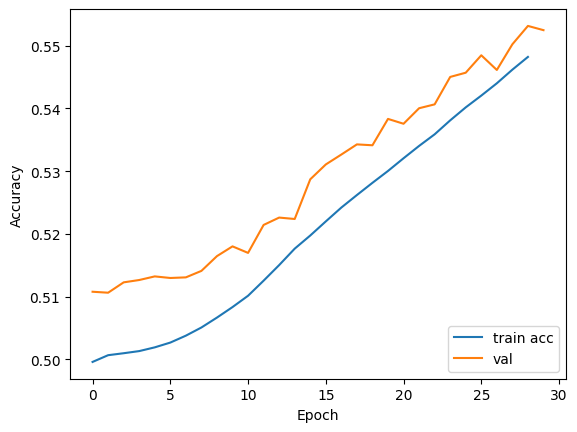

In [53]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

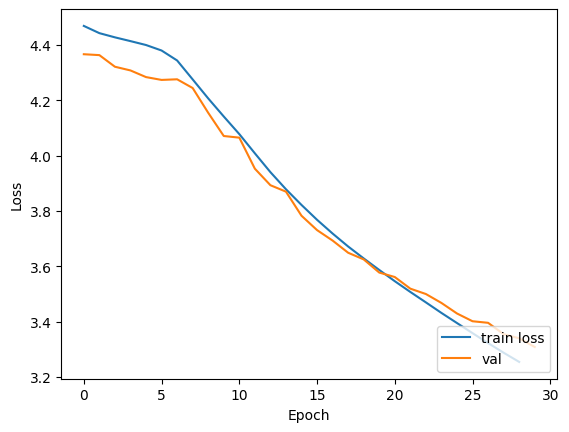

In [54]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [55]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [56]:
def build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_input_h = Input(shape=(latent_dim, ))
    decoder_state_input_c = Input(shape=(latent_dim, ))
    decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_lstm(
        decoder_embedding,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [57]:
encoder_model, decoder_model = build_seq2seq_model_with_just_lstm_inference(
    max_text_len, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [58]:
def decode_sequence_seq2seq_model_with_just_lstm(
    input_sequence, encoder_model, decoder_model, target_word_index, reverse_target_word_index, start_token, end_token, max_summary_len
):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + [e_out, e_h, e_c]
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_summary_len - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence


In [59]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if (
            (i != 0 and i != target_word_index[start_token]) and
            (i != target_word_index[end_token])
        ):
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [60]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [61]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


In [62]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = clean_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_text_len:
        text = expand_contractions(text)
        text = clean_text(text)
        text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_text_len, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_text_len), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_text_len texts and predicting on them
        while len(text_list) % max_text_len == 0:
            text_list.append('')

        lst_i = max_text_len
        for i in range(0, len(text_list), max_text_len):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_text_len == 0

            _text = expand_contractions(_text)
            _text = clean_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_text_len, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_text_len), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [65]:
# Testing on training data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_train_padded[i]))
    print("Original summary: ", seq2summary(y_train_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_train_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model, target_word_index, reverse_target_word_index, # Adding missing arguments
            start_token, end_token, max_summary_len
        )
    )
    print()

# 1 News:  amid ongoing diplomatic row saudi arabia canada verified saudi twitter account posted like image showing air canada flight heading towards torontofs cn tower saudi suspended ties canada last week north american nation called kingdom release detained civil society womens rights activists 
Original summary:  start saudi twitter account threatens canada like image end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted summary:   start saudi arabia saudi arabia saudi arabia end

# 2 News:  train accidents last five years caused due derailments according government data derailment indorepatna express mber claimed lives people others injured rec

In [67]:
# Testing on validation data
for i in range(0, 15):
    print(f"# {i+1} News: ", seq2text(x_val_padded[i]))
    print("Original summary: ", seq2summary(y_val_padded[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_just_lstm(
            x_val_padded[i].reshape(1, max_text_len), encoder_model,
            decoder_model, target_word_index, reverse_target_word_index, # Adding missing arguments
            start_token, end_token, max_summary_len # Adding missing arguments
        )
    )
    print()

# 1 News:  police arrested alleged mastermind behind gangrape five women ngo activists jharkhand women kidnapped armed men performing street play gangraped forest mastermind also suspected behind kidnapping four policthemen retaliation raids conducted arrest accused gangrape 
Original summary:  start mastermind behind rape ngo workers jkhand arrested end 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted summary:   start arrested arrested arrested arrested arrested end

# 2 News:  former delhi cm congress leader sheila dikshit autobiography citizen delhi times life claimed government smooth relations manmohan singhled centre referring handling commonwealth games subsequent allegations diks

In [69]:
# HDF5 format
model.save('model.keras')
encoder_model.save('encoder_model.keras')
decoder_model.save('decoder_model.keras')